<a href="https://colab.research.google.com/github/dindararas/Data-Science-Portfolio/blob/main/Classification/Multiclass%20Classification/Crop_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CROP RECOMMENDATION SYSTEM**

Agriculture plays an important role in both economy and food production in most of countries. Today's agriculture has to maximize productivity while adapting to climate change and land-use competition. The greatest challenge for most farmers is being abe to decide what crop to grow and where. In this project, I use several kinds of machine learning to decide what's the best crop to grow. Proposed machine learning :
1. Logistic Regression
2. Random Forest Classifier
3. Decision Tree Classifier
4. AdaBoost Classifier
5. XGBoost Classifier
6. LightGBM
7. Naive Bayes

## **1. IMPORTING LIBRARY**

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd

# Libraries for data visualization
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Useful libraries
import warnings
warnings.filterwarnings('ignore')

# Library for clustering
from sklearn.cluster import KMeans

# Sklearn libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,  confusion_matrix, classification_report

# Libraries for machine learning algorithm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier

## **2. LOADING DATASET**

In [ ]:
crop = pd.read_csv('/content/Crop_recommendation.csv')

In [ ]:
crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
print(f'Shape of dataframe : {crop.shape[0]} rows and {crop.shape[1]} columns')

Shape of dataframe : 2200 rows and 8 columns


## **3. EXPLORATORY DATA ANALYSIS**

### **3.1 Check Null Values**

In [ ]:
crop.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

### **3.2 Check Various Crops in Dataset**

In [ ]:
print(f'Number of various crops : {len(crop.label.unique())}')
print(f'List of crops : {crop.label.unique()}')

Number of various crops : 22
List of crops : ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In this dataset, there are 22 kinds of crops. Let's check whether this data is balanced or not

In [ ]:
val = pd.DataFrame(crop.label.value_counts())
val.reset_index(inplace = True)
val.rename(columns = {'index' : 'Label', 'label' : 'Count'}, inplace = True)
# Check whether data is balanced or not
fig = px.bar(val, x = 'Label', y = 'Count', title = 'Checking Data')
fig.show()

It can be seen that all of crops have the same quantity in this dataset, so there's no need to do data transformation regarding imbalanced data

### **3.3 Parameter Analysis**

#### **Temperature Range** 

In [ ]:
fig = px.box(crop, x='label', y='temperature')
fig.update_layout(title_text = 'Temperature Required')
fig.show()

It can be seen that grapes and oranges can be planted in a wide range of air temperature from low temperature (around 10 degrees Celcius) to high temperature (above 30 degrees Celcius). Papaya can also live in a wide range of air temperature, but it tends to live in hotter temperature (23 - 43 degrees Celcius). It makes sense because papaya is tropical fruit, while grapes and oranges are originally subtropical fruits.

#### **Humidity Range**

In [ ]:
fig = px.box(crop, x='label', y='humidity')
fig.update_layout(title_text = 'Humidity Required')
fig.show()

Half of crops in this dataset require the minimum humidity of 80%, while chickpeas and kidneybeans require very low humidity (around 20 degrees Celcius) 

#### **pH Range**

In [ ]:
fig = px.box(crop, x='label', y='ph')
fig.update_layout(title_text = 'pH Required')
fig.show()

##### There is relationship between soil pH and nutrient availability
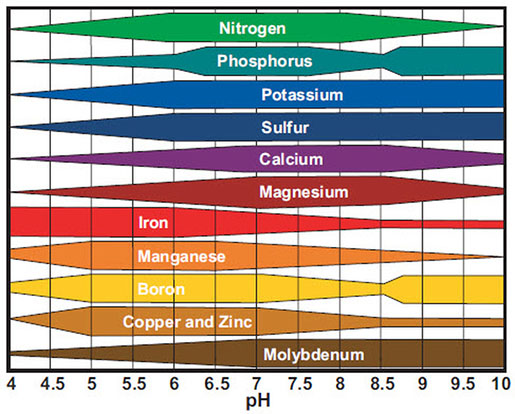

Most of crops live in the soil with the pH of 6.00 - 7.00. We can see that in the figure, macronutrients needed by plants are availabe and can be optimally absorbed in the pH range of 6.0 - 7.0. Thus, most of crops in this dataset live in the this range to obtain macronutrients in the soil easily. In contrast, mothbeans can live in acid, neutral, and base soils. From the figure above, plants living in the acid soil will find it more difficult to get macronutrients (nitrogen, potassium, phosporus, calcium, sulfur, and magnesium). Mothbeans is one of legumes that can fix the nitrogen from soil, so as long as pH is suitable for microbes-associated with mothbeans' roots, mothbeans can still get sufficient nitrogen in acid soil.

#### **Rainfall Range**

In [ ]:
fig = px.box(crop, x='label', y='rainfall')
fig.update_layout(title_text = 'Rainfall Required')
fig.show()

Rice requires high precipitation (above 200 mm) since it is planted in the wet field, while other crops are planted in the normal condition. Papaya can live in the environment with a wide range of precipitation from low precipitation (40.35 mm) to high precipitation (248.86 mm).

#### **Nitrogen Analysis**

In [ ]:
# Make pivot to make data visualization easier
crop_pivot = pd.pivot_table(crop, index = 'label', aggfunc = 'mean')

crop_pivot.head()

,K,N,P,humidity,ph,rainfall,temperature
label,,,,,,,
apple,199.89,20.80,134.22,92.333383,5.929663,112.654779,22.630942
banana,50.05,100.23,82.01,80.358123,5.983893,104.626980,27.376798
blackgram,19.24,40.02,67.47,65.118426,7.133952,67.884151,29.973340
chickpea,79.92,40.09,67.79,16.860439,7.336957,80.058977,18.872847
coconut,30.59,21.98,16.93,94.844272,5.976562,175.686646,27.409892


In [ ]:
crop_N = crop_pivot.sort_values(by = 'N', ascending = False)
fig = make_subplots(rows = 1, cols = 2)
# Data for top 11 crops that need most and least nitrogen
most = {'x' : crop_N['N'][:11].sort_values(ascending = True), 
        'y' : crop_N['N'][:11].sort_values(ascending = True).index}

least = {'x' : crop_N['N'][-11:].sort_values(ascending = False), 
        'y' : crop_N['N'][-11:].sort_values(ascending = False).index}

# Bar plot for top 11 crops that need most and nitrogen
fig.add_trace(go.Bar(most, name = 'Most Nitrogen Required', orientation = 'h', text=most['x']), row =1, col =1)
fig.add_trace(go.Bar(least, name = 'Least Nitrogen Required', orientation = 'h', text = least['x']), row =1, col =2)

# Settings
fig.update_traces(texttemplate='%{text}', textposition='inside')
fig.update_layout(title_text = 'Nitrogen Requirement', plot_bgcolor = 'white')

fig.show()

It can bee seen that coconut, coffee, muskmelon, and banana need above 100 kg/ha which is around 5 times higher compared to lentil, pomagranate, and orange

### **Phosporus Analysis**

In [ ]:
crop_P = crop_pivot.sort_values(by = 'P', ascending = False)
fig = make_subplots(rows = 1, cols = 2)

# Data for top 11 crops that need most and lest phosporus
most = {'x' : crop_P['P'][:11].sort_values(ascending = True), 
        'y' : crop_P['P'][:11].sort_values(ascending = True).index}

least = {'x' : crop_P['P'][-11:].sort_values(ascending = False), 
        'y' : crop_P['P'][-11:].sort_values(ascending = False).index}

# Bar plot for top 11 crops that need most and least phosporus
fig.add_trace(go.Bar(most, name = 'Most Phosporus Required', orientation = 'h', text=most['x']), row =1, col =1)
fig.add_trace(go.Bar(least, name = 'Least Phosporus Required', orientation = 'h', text = least['x']), row =1, col =2)

# Settings
fig.update_traces(texttemplate='%{text}', textposition='inside')
fig.update_layout(title_text = 'Phosporus Requirement', plot_bgcolor = 'white')

fig.show()

Apple and grape need phosporus the most. While other countries need phosporus at below 100 kg/ha, apple and grape require 134.22 kg/ha and 132.54, respectively.

#### **Potassium Analysis**

In [ ]:
crop_K = crop_pivot.sort_values(by = 'K', ascending = False)
fig = make_subplots(rows = 1, cols = 2)

# Data for top 11 crops that need most and lest potassium
most = {'x' : crop_K['K'][:11].sort_values(ascending = True), 
        'y' : crop_K['K'][:11].sort_values(ascending = True).index}

least = {'x' : crop_K['K'][-11:].sort_values(ascending = False), 
        'y' : crop_K['K'][-11:].sort_values(ascending = False).index}

# Bar plot for top 11 crops that need most and least potassium
fig.add_trace(go.Bar(most, name = 'Most Potassium Required', orientation = 'h', text=most['x']), row =1, col =1)
fig.add_trace(go.Bar(least, name = 'Least Potassium Required', orientation = 'h', text = least['x']), row =1, col =2)

# Settings
fig.update_traces(texttemplate='%{text}', textposition='inside')
fig.update_layout(title_text = 'Potassium Requirement', plot_bgcolor = 'white')

fig.show()

For potassium requirement, apple and grape are also fruits that need high potassium. 

### **N, P, K Ratio Among Staple Food** 

I want to check NPK ratio among staple food and fruits

In [ ]:
# Reset index
crop_pivot.reset_index(inplace = True)

labels = ['K', 'N', 'P']
rows = 2
cols =5
specs = [[{'type':'domain'}] * cols] * rows
fig = make_subplots(rows = rows, cols = cols, specs = specs)

rice_npk = crop_pivot[crop_pivot['label'] == 'rice']
npk = list(rice_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist())
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Rice'), row = 1, col =1)

maize_npk = crop_pivot[crop_pivot['label'] == 'maize']
npk = maize_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Maize'), row = 1, col =2)

kidney_npk = crop_pivot[crop_pivot['label'] == 'kidneybeans']
npk = kidney_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Kidneybeans'), row = 1, col =3)

mung_npk = crop_pivot[crop_pivot['label'] == 'mungbean']
npk = mung_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Mungbeans'), row = 1, col =4)

chick_npk = crop_pivot[crop_pivot['label'] == 'chickpea']
npk = chick_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Chickpeas'), row = 1, col =5)

moth_npk = crop_pivot[crop_pivot['label'] == 'mothbeans']
npk = moth_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Mothbeans'), row = 2, col =1)

jute_npk = crop_pivot[crop_pivot['label'] == 'jute']
npk = jute_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Jute'), row = 2, col =2)

black_npk = crop_pivot[crop_pivot['label']  == 'blackgram']
npk = black_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Blackgram'), row = 2, col =3)

lentil_npk = crop_pivot[crop_pivot['label']  == 'lentil']
npk = lentil_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Lentil'), row = 2, col =4)

pigeon_npk = crop_pivot[crop_pivot['label'] == 'pigeonpeas']
npk = pigeon_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Pigeonpeas'), row = 2, col =5)

fig.update_traces( hoverinfo="label+percent+name"),
fig.update_layout(title_text='Comparison of NPK Ratio for Staple Food', annotations=[dict(text='Rice',x=0.06,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Maize',x=0.26,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Kidneybeans',x=0.50,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Mungbean',x=0.74,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Chickpea',x=0.94,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Mothbeans',x=0.06,y=0.46, font_size=15, showarrow=False),
                                                                   dict(text='Jute',x=0.26,y=0.46, font_size=15, showarrow=False),
                                                                   dict(text='Blackgram',x=0.50,y=0.46, font_size=15, showarrow=False),
                                                                   dict(text='Lentil',x=0.74,y=0.46, font_size=15, showarrow=False),
                                                                   dict(text='Pigeonpeas',x=0.94,y=0.46, font_size=15, showarrow=False)])
fig.show()

#### **N,P,K Ratio Among Fruits**

In [ ]:
labels = ['K', 'N', 'P']
rows = 2
cols =5
specs = [[{'type':'domain'}] * cols] * rows
fig = make_subplots(rows = rows, cols = cols, specs = specs)

rice_npk = crop_pivot[crop_pivot['label'] == 'apple']
npk = list(rice_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist())
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Apple'), row = 1, col =1)

maize_npk = crop_pivot[crop_pivot['label'] == 'banana']
npk = maize_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Banana'), row = 1, col =2)

kidney_npk = crop_pivot[crop_pivot['label'] == 'grapes']
npk = kidney_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Grapes'), row = 1, col =3)

mung_npk = crop_pivot[crop_pivot['label'] == 'watermelon']
npk = mung_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Watermelon'), row = 1, col =4)

chick_npk = crop_pivot[crop_pivot['label'] == 'muskmelon']
npk = chick_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Muskmelon'), row = 1, col =5)

moth_npk = crop_pivot[crop_pivot['label'] == 'coconut']
npk = moth_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Coconut'), row = 2, col =1)

jute_npk = crop_pivot[crop_pivot['label'] == 'papaya']
npk = jute_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Papaya'), row = 2, col =2)

black_npk = crop_pivot[crop_pivot['label']  == 'mango']
npk = black_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Blackgram'), row = 2, col =3)

lentil_npk = crop_pivot[crop_pivot['label']  == 'pomegranate']
npk = lentil_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Pomegranate'), row = 2, col =4)

pigeon_npk = crop_pivot[crop_pivot['label'] == 'orange']
npk = pigeon_npk.loc[:, 'K' : 'P'].to_numpy().flatten().tolist()
fig.add_trace(go.Pie(labels = labels, values = npk, name = 'Orange'), row = 2, col =5)

fig.update_traces( hoverinfo="label+percent+name"),
fig.update_layout(title_text='Comparison of NPK Ratio for Fruits', annotations=[dict(text='Apple',x=0.06,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Banana',x=0.26,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Grapes',x=0.50,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Watermelon',x=0.74,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Muskmelon',x=0.94,y=1.08, font_size=15, showarrow=False),
                                                                   dict(text='Coconut',x=0.06,y=0.46, font_size=15, showarrow=False),
                                                                   dict(text='Papaya',x=0.26,y=0.46, font_size=15, showarrow=False),
                                                                   dict(text='Mango',x=0.50,y=0.46, font_size=15, showarrow=False),
                                                                   dict(text='Pomegranate',x=0.74,y=0.46, font_size=15, showarrow=False),
                                                                   dict(text='Orange',x=0.94,y=0.46, font_size=15, showarrow=False)])
fig.show()

#### **All Parameters for All Crops**

In [ ]:
fig = px.scatter_matrix(crop,
    dimensions=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'],
    color= 'label', symbol='label',
    title='Scatter matrix of crops',
    labels={col:col.replace('_', ' ') for col in crop.columns})
fig.update_traces(diagonal_visible=False)
fig.show()

Based on the graph, it can be concluded that :
1. Soil with pH in the range of (6.00 - 7.00) tend to have more Nitrogen and Phosporus.
2. Rice requires high intensity of rainfall. This makes sense because most of rice varieties have better growth and produce higher yield when grown in flooded soils. 
3. Majority of crops live in soil with neutral pH. Only mothbeans can live in soils with a wide range of pH (between 3.5 - 9.7).
4. Chickpea and kidneybeans require the lowest humidity which is around 15% and also low rainfall. 

## **4. CLUSTERING**

#### **Temperature and Humidity**

In [ ]:
# Select the temperature and humidity columns
x = crop.loc[:, ['temperature','humidity']].values

# Find the optimal number of clusters by the elbow method
wcss=[]
for k in range(1,11):
  km=KMeans(n_clusters=k, init = 'k-means++')
  km.fit(x)
  wcss.append(km.inertia_)

#The elbow curve
fig = go.Figure(data = go.Scatter(x = [1,2,3,4,5,6,7,8,9,10], y = wcss))
fig.update_layout(title = 'WCSS vs Cluster Number', xaxis_title = 'Clusters', yaxis_title = 'WCSS')
fig.show()

From the line-chart above, we can observe that the “elbow” is the number 3 which is the optimal clusters (center) in this case.

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
kmeans_pred = kmeans.fit_predict(x)

# lets find out the Results
cluster = crop.copy()
cluster['cluster'] = kmeans_pred

# lets check the Clusters of each Crops
print("Lets check the Results After Applying the K Means Clustering Analysis \n")
print("Crops in First Cluster:", cluster[cluster['cluster'] == 0]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in Second Cluster:", cluster[cluster['cluster'] == 1]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in Third Cluster:", cluster[cluster['cluster'] == 2]['label'].unique())


Lets check the Results After Applying the K Means Clustering Analysis 

Crops in First Cluster: ['maize' 'pigeonpeas' 'mothbeans' 'blackgram' 'lentil' 'mango' 'jute'
 'coffee']
---------------------------------------------------------------
Crops in Second Cluster: ['chickpea' 'kidneybeans' 'pigeonpeas']
---------------------------------------------------------------
Crops in Third Cluster: ['rice' 'maize' 'mungbean' 'pomegranate' 'banana' 'grapes' 'watermelon'
 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton' 'jute']


In [ ]:
# Visualizing cluster
fig = px.scatter(cluster, x = 'temperature', y = 'humidity', color = 'cluster')
fig.show()

##### **N,P,K**

In [ ]:
# Select the N, P, and K columns
x = crop.loc[:, ['N','P', 'K']].values

# Find the optimal number of clusters by the elbow method
wcss2=[]
for k in range(1,11):
  km=KMeans(n_clusters=k, init = 'k-means++')
  km.fit(x)
  wcss2.append(km.inertia_)

#The elbow curve
fig = go.Figure(data = go.Scatter(x = [1,2,3,4,5,6,7,8,9,10], y = wcss2))
fig.update_layout(title = 'WCSS vs Cluster Number', xaxis_title = 'Clusters', yaxis_title = 'WCSS')
fig.show()

In [ ]:
kmeans2 = KMeans(n_clusters = 3, init = 'k-means++')
kmeans_pred2 = kmeans2.fit_predict(x)

# lets find out the Results
cluster2 = crop.copy()
cluster2['cluster'] = kmeans_pred2

# lets check the Clusters of each Crops
print("Lets check the Results After Applying the K Means Clustering Analysis \n")
print("Crops in First Cluster:", cluster2[cluster2['cluster'] == 0]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in Second Cluster:", cluster2[cluster2['cluster'] == 1]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in Third Cluster:", cluster2[cluster2['cluster'] == 2]['label'].unique())

Lets check the Results After Applying the K Means Clustering Analysis 

Crops in First Cluster: ['maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans' 'mungbean'
 'blackgram' 'lentil' 'pomegranate' 'mango' 'orange' 'papaya' 'coconut']
---------------------------------------------------------------
Crops in Second Cluster: ['grapes' 'apple']
---------------------------------------------------------------
Crops in Third Cluster: ['rice' 'maize' 'chickpea' 'banana' 'watermelon' 'muskmelon' 'papaya'
 'cotton' 'jute' 'coffee']


In [ ]:
fig = px.scatter_3d(cluster2, x = 'N', y='P', z='K', color = 'cluster', opacity = 0.8)
fig.show()

## **5. DATA PRE-PROCESSING**

In [ ]:
# Feature selection
x = crop.drop('label', axis=1)
y = crop['label']

# train-test split
x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = 0.3)

print(f'Shape of x_train : {x_train.shape}')
print(f'Shape of x_test : {x_test.shape}')
print(f'Shape of y_train : {y_train.shape}')
print(f'Shape of y_test : {y_test.shape}')

Shape of x_train : (1540, 7)
Shape of x_test : (660, 7)
Shape of y_train : (1540,)
Shape of y_test : (660,)


## **6. MODEL SELECTION**

In [ ]:
# Dataframe to compare accuracy every model
model_comparison = pd.DataFrame(columns = ['Model', 'Accuracy', 'Training Accuracy'])

# Function for building model
def model_building(model, x_train = x_train, y_train = y_train, x_test = x_test, y_test =  y_test ) :
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  acc = accuracy_score(y_test, y_pred)
  train_pred = model.predict(x_train)
  train_acc = accuracy_score(y_train, train_pred)
  return y_pred, acc, train_acc
 

### **6.1 Logistic Regression**

In [ ]:
log = LogisticRegression()

log_pred, log_acc, log_train_acc = model_building(log)
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        22
      banana       1.00      1.00      1.00        36
   blackgram       0.94      0.94      0.94        31
    chickpea       1.00      1.00      1.00        36
     coconut       0.97      1.00      0.98        31
      coffee       0.97      1.00      0.98        30
      cotton       0.86      0.94      0.90        34
      grapes       1.00      1.00      1.00        23
        jute       0.97      0.88      0.92        34
 kidneybeans       0.90      0.96      0.93        27
      lentil       0.93      0.93      0.93        28
       maize       0.83      0.76      0.79        25
       mango       1.00      1.00      1.00        28
   mothbeans       1.00      0.88      0.93        32
    mungbean       0.95      1.00      0.97        39
   muskmelon       1.00      1.00      1.00        31
      orange       1.00      1.00      1.00        27
      papaya       1.00    

In [ ]:
# Append accuracy and training accuracy of Logistic Regression
model_comparison = model_comparison.append({'Model' : 'Logistic Regression', 'Accuracy' : log_acc, 'Training Accuracy' : log_train_acc}, ignore_index = True)
model_comparison

,Model,Accuracy,Training Accuracy
0,Logistic Regression,0.960606,0.966883


### **6.2 Random Forest**

In [ ]:
rf = RandomForestClassifier()
rf_pred, rf_acc, rf_train_acc = model_building(rf)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        22
      banana       1.00      1.00      1.00        36
   blackgram       1.00      0.97      0.98        31
    chickpea       1.00      1.00      1.00        36
     coconut       1.00      1.00      1.00        31
      coffee       1.00      1.00      1.00        30
      cotton       1.00      1.00      1.00        34
      grapes       1.00      1.00      1.00        23
        jute       1.00      1.00      1.00        34
 kidneybeans       1.00      1.00      1.00        27
      lentil       0.97      1.00      0.98        28
       maize       0.96      1.00      0.98        25
       mango       1.00      1.00      1.00        28
   mothbeans       1.00      0.97      0.98        32
    mungbean       1.00      1.00      1.00        39
   muskmelon       1.00      1.00      1.00        31
      orange       1.00      1.00      1.00        27
      papaya       1.00    

In [ ]:
# Append accuracy and training accuracy 
model_comparison = model_comparison.append({'Model' : 'Random Forest', 'Accuracy' : rf_acc, 'Training Accuracy' : rf_train_acc}, ignore_index = True)
model_comparison

,Model,Accuracy,Training Accuracy
0,Logistic Regression,0.960606,0.966883
1,Random Forest,0.996970,1.000000


### **6.3 Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier()
dt_pred, dt_acc, dt_train_acc = model_building(dt)
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        22
      banana       1.00      1.00      1.00        36
   blackgram       0.97      0.97      0.97        31
    chickpea       1.00      1.00      1.00        36
     coconut       1.00      1.00      1.00        31
      coffee       1.00      1.00      1.00        30
      cotton       1.00      1.00      1.00        34
      grapes       1.00      1.00      1.00        23
        jute       1.00      0.94      0.97        34
 kidneybeans       1.00      1.00      1.00        27
      lentil       0.93      1.00      0.97        28
       maize       0.96      1.00      0.98        25
       mango       1.00      1.00      1.00        28
   mothbeans       1.00      0.91      0.95        32
    mungbean       1.00      1.00      1.00        39
   muskmelon       1.00      1.00      1.00        31
      orange       1.00      1.00      1.00        27
      papaya       1.00    

In [ ]:
# Append accuracy and training accuracy 
model_comparison = model_comparison.append({'Model' : 'Decision Tree', 'Accuracy' : dt_acc, 'Training Accuracy' : dt_train_acc}, ignore_index = True)
model_comparison

,Model,Accuracy,Training Accuracy
0,Logistic Regression,0.960606,0.966883
1,Random Forest,0.996970,1.000000
2,Decision Tree,0.990909,1.000000


### **6.4 AdaBoost Classifier**

In [ ]:
ab = AdaBoostClassifier()
ab_pred, ab_acc, ab_train_acc = model_building(ab)
print(classification_report(y_test, ab_pred))

              precision    recall  f1-score   support

       apple       0.49      1.00      0.66        22
      banana       0.00      0.00      0.00        36
   blackgram       0.00      0.00      0.00        31
    chickpea       1.00      1.00      1.00        36
     coconut       0.00      0.00      0.00        31
      coffee       0.00      0.00      0.00        30
      cotton       0.00      0.00      0.00        34
      grapes       0.00      0.00      0.00        23
        jute       0.00      0.00      0.00        34
 kidneybeans       1.00      1.00      1.00        27
      lentil       0.00      0.00      0.00        28
       maize       0.00      0.00      0.00        25
       mango       0.00      0.00      0.00        28
   mothbeans       0.00      0.00      0.00        32
    mungbean       0.00      0.00      0.00        39
   muskmelon       1.00      1.00      1.00        31
      orange       0.00      0.00      0.00        27
      papaya       0.00    

In [ ]:
# Append accuracy and training accuracy 
model_comparison = model_comparison.append({'Model' : 'AdaBoost Classifier', 'Accuracy' : ab_acc, 'Training Accuracy' : ab_train_acc}, ignore_index = True)
model_comparison

,Model,Accuracy,Training Accuracy
0,Logistic Regression,0.960606,0.966883
1,Random Forest,0.996970,1.000000
2,Decision Tree,0.990909,1.000000
3,AdaBoost Classifier,0.210606,0.234416


### **6.5 XGBoost**

In [ ]:
xgb = XGBClassifier()
xgb_pred, xgb_acc, xgb_train_acc = model_building(xgb)
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        22
      banana       1.00      1.00      1.00        36
   blackgram       0.94      0.97      0.95        31
    chickpea       1.00      1.00      1.00        36
     coconut       1.00      1.00      1.00        31
      coffee       1.00      1.00      1.00        30
      cotton       1.00      1.00      1.00        34
      grapes       1.00      1.00      1.00        23
        jute       0.97      0.94      0.96        34
 kidneybeans       1.00      1.00      1.00        27
      lentil       0.90      0.96      0.93        28
       maize       0.96      1.00      0.98        25
       mango       1.00      1.00      1.00        28
   mothbeans       1.00      0.88      0.93        32
    mungbean       1.00      1.00      1.00        39
   muskmelon       1.00      1.00      1.00        31
      orange       1.00      1.00      1.00        27
      papaya       1.00    

In [ ]:
# Append accuracy and training accuracy 
model_comparison = model_comparison.append({'Model' : 'XGBoost', 'Accuracy' : xgb_acc, 'Training Accuracy' : xgb_train_acc}, ignore_index = True)
model_comparison

,Model,Accuracy,Training Accuracy
0,Logistic Regression,0.960606,0.966883
1,Random Forest,0.996970,1.000000
2,Decision Tree,0.990909,1.000000
3,AdaBoost Classifier,0.210606,0.234416
4,XGBoost,0.986364,1.000000


### **6.6 Naive Bayes**

In [ ]:
nb = GaussianNB()
nb_pred, nb_acc, nb_train_acc = model_building(nb)
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        22
      banana       1.00      1.00      1.00        36
   blackgram       1.00      1.00      1.00        31
    chickpea       1.00      1.00      1.00        36
     coconut       1.00      1.00      1.00        31
      coffee       1.00      1.00      1.00        30
      cotton       0.97      1.00      0.99        34
      grapes       1.00      1.00      1.00        23
        jute       0.97      1.00      0.99        34
 kidneybeans       1.00      1.00      1.00        27
      lentil       1.00      1.00      1.00        28
       maize       1.00      0.96      0.98        25
       mango       1.00      1.00      1.00        28
   mothbeans       1.00      1.00      1.00        32
    mungbean       1.00      1.00      1.00        39
   muskmelon       1.00      1.00      1.00        31
      orange       1.00      1.00      1.00        27
      papaya       1.00    

In [ ]:
# Append accuracy and training accuracy 
model_comparison = model_comparison.append({'Model' : 'Naive Bayes', 'Accuracy' : nb_acc, 'Training Accuracy' : round(nb_train_acc,2)}, ignore_index = True)
model_comparison

,Model,Accuracy,Training Accuracy
0,Logistic Regression,0.960606,0.966883
1,Random Forest,0.996970,1.000000
2,Decision Tree,0.990909,1.000000
3,AdaBoost Classifier,0.210606,0.234416
4,XGBoost,0.986364,1.000000
5,Naive Bayes,0.996970,0.990000


### **6.7 LightGBM**

In [ ]:
lgb = LGBMClassifier()
lgb_pred, lgb_acc, lgb_train_acc = model_building(lgb)
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        22
      banana       1.00      1.00      1.00        36
   blackgram       0.97      1.00      0.98        31
    chickpea       1.00      1.00      1.00        36
     coconut       1.00      1.00      1.00        31
      coffee       1.00      1.00      1.00        30
      cotton       1.00      1.00      1.00        34
      grapes       1.00      1.00      1.00        23
        jute       1.00      1.00      1.00        34
 kidneybeans       1.00      1.00      1.00        27
      lentil       0.90      1.00      0.95        28
       maize       1.00      1.00      1.00        25
       mango       1.00      1.00      1.00        28
   mothbeans       1.00      0.88      0.93        32
    mungbean       1.00      1.00      1.00        39
   muskmelon       1.00      1.00      1.00        31
      orange       1.00      1.00      1.00        27
      papaya       1.00    

In [ ]:
# Append accuracy and training accuracy 
model_comparison = model_comparison.append({'Model' : 'Light GBM', 'Accuracy' : lgb_acc, 'Training Accuracy' : lgb_train_acc}, ignore_index = True)
model_comparison

,Model,Accuracy,Training Accuracy
0,Logistic Regression,0.960606,0.966883
1,Random Forest,0.996970,1.000000
2,Decision Tree,0.990909,1.000000
3,AdaBoost Classifier,0.210606,0.234416
4,XGBoost,0.986364,1.000000
5,Naive Bayes,0.996970,0.990000
6,Light GBM,0.993939,1.000000


### **Model Comparison**

In [ ]:
model_comparison = model_comparison.round(decimals = 3)
fig = make_subplots(rows = 1, cols = 2)
# Data for comparison of accuracy and training accuracy
acc = {'x' : model_comparison['Accuracy'], 'y' : model_comparison['Model']}

train_acc = {'x' : model_comparison['Training Accuracy'], 'y' : model_comparison['Model']}

# Bar plot for top 11 crops that need most and nitrogen
fig.add_trace(go.Bar(acc, name = 'Accuracy Score', orientation = 'h', text=acc['x']), row =1, col =1)
fig.add_trace(go.Bar(train_acc, name = 'Training Accuracy Score', orientation = 'h', text = train_acc['x']), row =1, col =2)

# Settings
fig.update_traces(texttemplate='%{text}', textposition='inside')
fig.update_layout(title_text = 'Model Comparison', plot_bgcolor = 'white')

fig.show()

Based on the graph, it can be seen that **Random Forest** has the best training accuracy and testing accuracy, which are **1** and **0.997** respectively

## **7. PREDICTION**

I want to do prediction by using random forest

In [ ]:
crop[crop['label'] == 'rice'].head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
# input the number that is similar to the required parameters for rice
prediction = rf.predict((np.array([[90,
                                       40,
                                       40,
                                       20,
                                       80,
                                       7,
                                       200]])))
print("The Suggested Crop for Given Climatic Condition is :", prediction)

The Suggested Crop for Given Climatic Condition is : ['rice']


In [ ]:
crop[crop['label'] == 'orange'].head()

,N,P,K,temperature,humidity,ph,rainfall,label
1600,22,30,12,15.781442,92.510777,6.354007,119.035002,orange
1601,37,6,13,26.030973,91.508193,7.511755,101.284774,orange
1602,27,13,6,13.360506,91.356082,7.335158,111.226688,orange
1603,7,16,9,18.879577,92.043045,7.813917,114.665951,orange
1604,20,7,9,29.477417,91.578029,7.129137,111.172750,orange


In [ ]:
prediction = rf.predict((np.array([[20,
                                       30,
                                       10,
                                       15,
                                       90,
                                       7.5,
                                       100]])))
print("The Suggested Crop for Given Climatic Condition is :", prediction)

The Suggested Crop for Given Climatic Condition is : ['orange']


In [ ]:
crop[crop['label'] == 'jute'].head()

,N,P,K,temperature,humidity,ph,rainfall,label
2000,89,47,38,25.524690,72.248508,6.002525,151.886997,jute
2001,60,37,39,26.591050,82.941641,6.033485,161.247000,jute
2002,63,41,45,25.297818,86.887054,7.121934,196.624951,jute
2003,86,40,39,25.721009,88.165136,6.207460,175.608670,jute
2004,96,41,40,23.584193,72.004608,6.090060,190.424216,jute


In [ ]:
# lets do some Real time Predictions
prediction = rf.predict((np.array([[86,
                                       40,
                                       39,
                                       25,
                                       72,
                                       6.0,
                                       151]])))
print("The Suggested Crop for Given Climatic Condition is :", prediction)

The Suggested Crop for Given Climatic Condition is : ['jute']
